In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from skimage.feature import hog
import glob
import matplotlib.image as mpimg
import cv2


%matplotlib inline


In [11]:
car_images = glob.glob('vehicles/**/*.png')
non_car_images = glob.glob('non-vehicles/**/*.png')

In [12]:
# Adding the HOG Features 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise = vis, feature_vector=feature_vec)

        return features


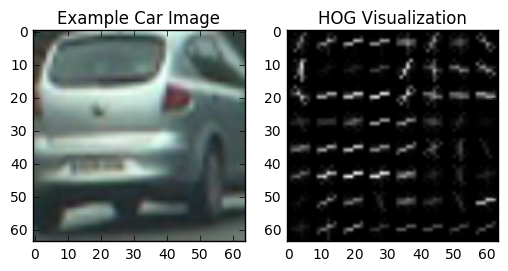

In [19]:
# Read in the image
image = mpimg.imread(car_images[764])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')